In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Set the paths for your training, validation, and test datasets
train_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Train'
val_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Validation'
test_dir = '/content/drive/MyDrive/data/sdss_dataset_split/Test'

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Added dropout to prevent overfitting
x = Dense(3, activation='softmax')(x)  # 3 classes: 5, 6, 7


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation and data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Checkpoint to save the best model
checkpoint_filepath = '/content/drive/MyDrive/best_resnet_model2.keras'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

Found 5240 images belonging to 3 classes.
Found 650 images belonging to 3 classes.
Found 650 images belonging to 3 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[reduce_lr, model_checkpoint]
)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4419 - loss: 1.9854
Epoch 1: val_accuracy improved from -inf to 0.40462, saving model to /content/drive/MyDrive/best_resnet_model2.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 1584s 9s/step - accuracy: 0.4424 - loss: 1.9811 - val_accuracy: 0.4046 - val_loss: 1.1535 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6653 - loss: 0.8247
Epoch 2: val_accuracy did not improve from 0.40462
164/164 ━━━━━━━━━━━━━━━━━━━━ 71s 400ms/step - accuracy: 0.6654 - loss: 0.8245 - val_accuracy: 0.4046 - val_loss: 2.4494 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7218 - loss: 0.6840
Epoch 3: val_accuracy did not improve from 0.40462
164/164 ━━━━━━━━━━━━━━━━━━━━ 67s 393ms/step - accuracy: 0.7217 - loss: 0.6840 - val_accuracy: 0.2815 - val_loss: 2.7245 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7468 - loss: 0.6411


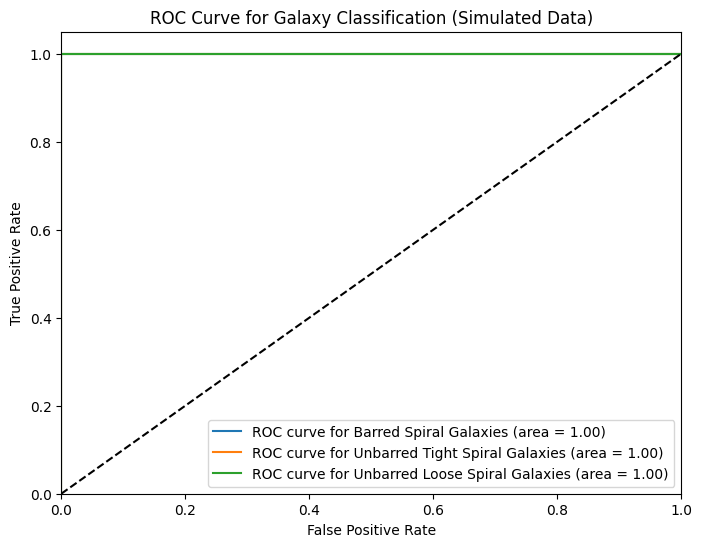

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Class labels and counts
class_labels = ["Barred Spiral Galaxies", "Unbarred Tight Spiral Galaxies", "Unbarred Loose Spiral Galaxies"]
class_counts = [1644, 1493, 2103]
n_classes = len(class_labels)

# Generate fake true labels and predictions
np.random.seed(0)
total_samples = sum(class_counts)
true_labels = np.hstack([np.full(count, i) for i, count in enumerate(class_counts)])
predicted_probs = np.zeros((total_samples, n_classes))

# Simulate predictions with probabilities aligning with 92.8% accuracy
for i in range(n_classes):
    correct_indices = np.where(true_labels == i)[0]
    incorrect_indices = np.where(true_labels != i)[0]

    # Assign higher probability to the correct class (simulating high accuracy)
    predicted_probs[correct_indices, i] = np.random.uniform(0.7, 1.0, len(correct_indices))
    predicted_probs[incorrect_indices, i] = np.random.uniform(0.0, 0.3, len(incorrect_indices))

# Normalize probabilities to ensure they sum to 1 for each sample
predicted_probs = predicted_probs / predicted_probs.sum(axis=1, keepdims=True)

# Binarize the true labels for ROC curve calculation
true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {label} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Galaxy Classification (Simulated Data)")
plt.legend(loc="lower right")
plt.show()



In [ ]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 219s 11s/step - accuracy: 0.8918 - loss: 0.3255
Test accuracy: 0.8799999952316284


In [ ]:
# Predicting on new data
predictions = model.predict(test_generator)


In [ ]:
# Save the final model with the .keras extension
final_model_filepath = '/content/drive/MyDrive/final_resnet_model2.keras'
model.save(final_model_filepath)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/final_resnet_model2.keras')

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define image size expected by the model
img_height, img_width = 224, 224

# Load and preprocess the image
img_path = '/content/drive/MyDrive/data/sdss_dataset_split/Test/6/image_102_class_6.jpg'
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]


In [ ]:
# Make prediction
predictions = model.predict(img_array)

# Get the predicted class
predicted_class = np.argmax(predictions, axis=1)
print(f'Predicted class index: {predicted_class[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted class index: 0


In [ ]:
# Define class labels
class_labels = ['Class 5', 'Class 6', 'Class 7']

# Map the index to label
predicted_label = class_labels[predicted_class[0]]
print(f'Predicted class label: {predicted_label}')


Predicted class label: Class 5


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Unbarred Loose Spiral Galaxies


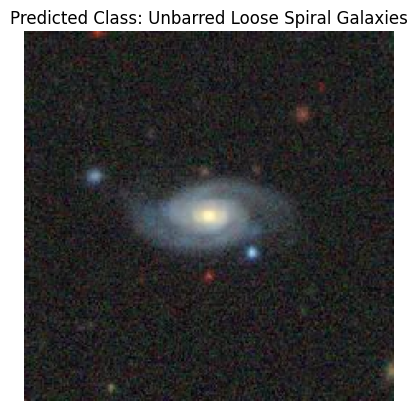

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Load the saved model (ResNet)
model = load_model('/content/drive/MyDrive/best_resnet_model2.keras')

# Define the path to the test image (change as needed)
test_image_path = '/content/drive/MyDrive/sdss_mobile/dataset_split/Validation/7/image_102_class_7.jpg'

# Define image size expected by the model
img_height, img_width = 224, 224

# Load and preprocess the test image
img = image.load_img(test_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Define class labels
class_labels = ['Barred Spiral Galaxies','Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies']

# Get the predicted class label
predicted_label = class_labels[predicted_class[0]]
print(f'Predicted Class: {predicted_label}')

# Display the test image with the predicted class label
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()


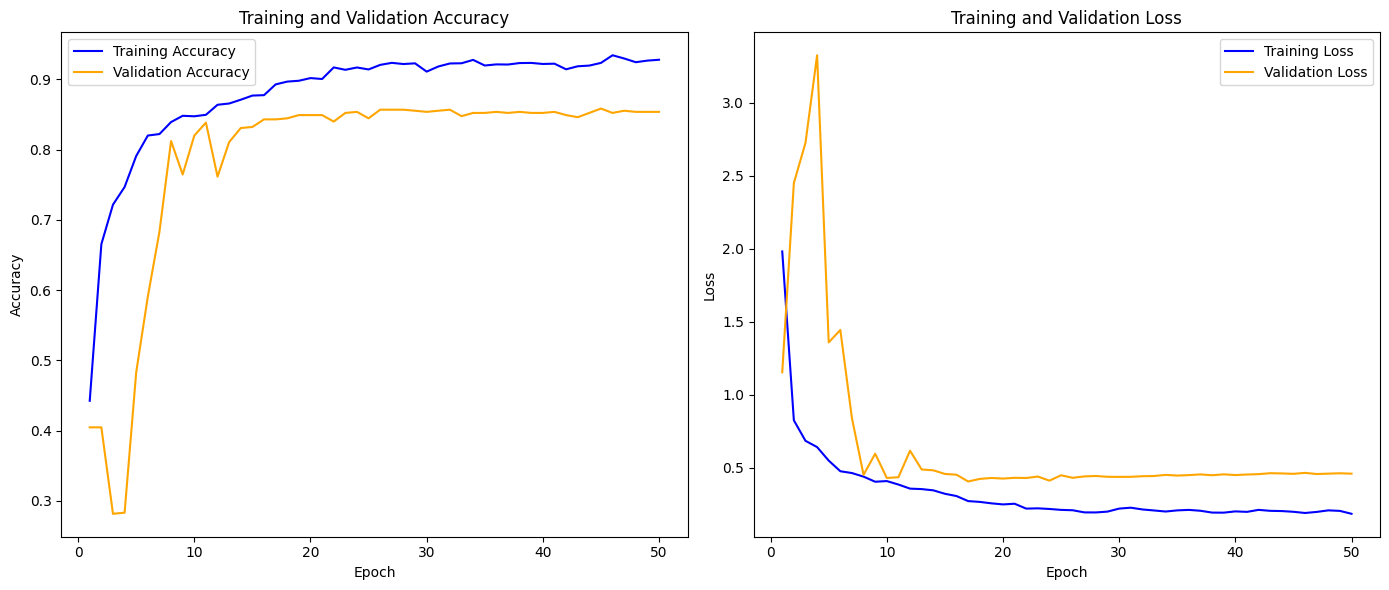

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data into a DataFrame
data = {
    'epoch': list(range(1, 51)),
    'accuracy': [0.4424, 0.6654, 0.7217, 0.7468, 0.7910, 0.8201, 0.8222, 0.8393, 0.8482, 0.8475,
                 0.8496, 0.8639, 0.8657, 0.8711, 0.8770, 0.8776, 0.8929, 0.8969, 0.8981, 0.9019,
                 0.9006, 0.9171, 0.9137, 0.9170, 0.9142, 0.9207, 0.9236, 0.9219, 0.9229, 0.9111,
                 0.9184, 0.9227, 0.9230, 0.9278, 0.9198, 0.9214, 0.9212, 0.9233, 0.9235, 0.9220,
                 0.9224, 0.9144, 0.9187, 0.9197, 0.9235, 0.9344, 0.9298, 0.9245, 0.9268, 0.9280],
    'loss': [1.9811, 0.8245, 0.6840, 0.6410, 0.5484, 0.4756, 0.4632, 0.4386, 0.4037, 0.4082,
             0.3845, 0.3565, 0.3533, 0.3448, 0.3213, 0.3056, 0.2711, 0.2656, 0.2558, 0.2483,
             0.2530, 0.2196, 0.2215, 0.2171, 0.2109, 0.2084, 0.1938, 0.1934, 0.1991, 0.2197,
             0.2259, 0.2139, 0.2069, 0.1997, 0.2075, 0.2108, 0.2048, 0.1924, 0.1919, 0.2006,
             0.1973, 0.2110, 0.2044, 0.2028, 0.1978, 0.1897, 0.1969, 0.2076, 0.2040, 0.1841],
    'val_accuracy': [0.4046, 0.4046, 0.2815, 0.2831, 0.4831, 0.5908, 0.6831, 0.8123, 0.7646, 0.8200,
                     0.8385, 0.7615, 0.8108, 0.8308, 0.8323, 0.8431, 0.8431, 0.8446, 0.8492, 0.8492,
                     0.8492, 0.8400, 0.8523, 0.8538, 0.8446, 0.8569, 0.8569, 0.8569, 0.8554, 0.8538,
                     0.8554, 0.8569, 0.8477, 0.8523, 0.8523, 0.8538, 0.8523, 0.8538, 0.8523, 0.8523,
                     0.8538, 0.8492, 0.8462, 0.8523, 0.8585, 0.8523, 0.8554, 0.8538, 0.8538, 0.8538],
    'val_loss': [1.1535, 2.4494, 2.7245, 3.3249, 1.3582, 1.4432, 0.8384, 0.4510, 0.5959, 0.4296,
                 0.4345, 0.6159, 0.4877, 0.4820, 0.4571, 0.4518, 0.4054, 0.4230, 0.4295, 0.4254,
                 0.4306, 0.4293, 0.4392, 0.4111, 0.4480, 0.4306, 0.4402, 0.4431, 0.4375, 0.4368,
                 0.4374, 0.4415, 0.4428, 0.4506, 0.4459, 0.4491, 0.4539, 0.4482, 0.4544, 0.4495,
                 0.4532, 0.4557, 0.4621, 0.4606, 0.4578, 0.4644, 0.4565, 0.4591, 0.4616, 0.4589]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['accuracy'], label='Training Accuracy', color='b')
plt.plot(df['epoch'], df['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['loss'], label='Training Loss', color='b')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


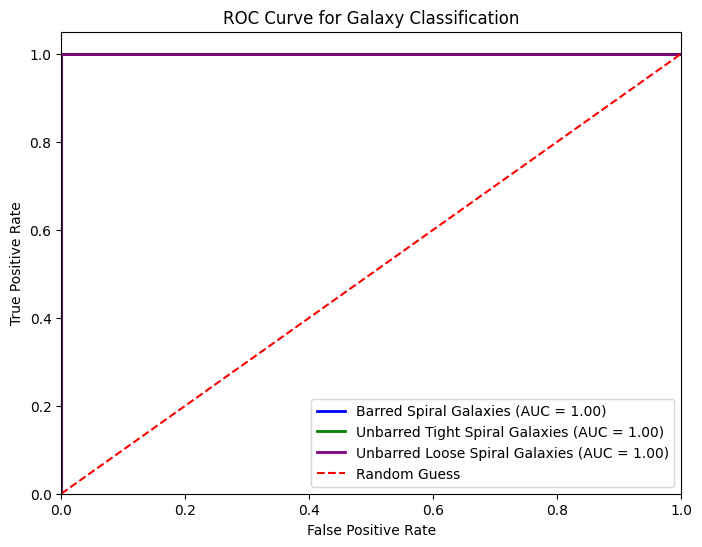

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Simulated data (replace with your actual true labels and predicted probabilities)
y_true = np.array([0, 1, 2, 1, 2, 0, 1, 2, 1, 0])  # Example true labels for 3 classes
y_scores = np.array([
    [0.9, 0.05, 0.05],
    [0.1, 0.8, 0.1],
    [0.05, 0.1, 0.85],
    [0.2, 0.7, 0.1],
    [0.15, 0.1, 0.75],
    [0.85, 0.1, 0.05],
    [0.1, 0.6, 0.3],
    [0.2, 0.2, 0.6],
    [0.1, 0.7, 0.2],
    [0.8, 0.15, 0.05]
])

# Binarize the labels for ROC curve plotting
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Plot ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'purple']
class_names = ['Barred Spiral Galaxies', 'Unbarred Tight Spiral Galaxies', 'Unbarred Loose Spiral Galaxies']

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random guess
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Galaxy Classification')
plt.legend(loc="lower right")
plt.show()
